In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from netCDF4 import Dataset
import pandas as pd
import properscoring as ps
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import warnings
import xarray as xr
from matplotlib import cm
from utils.evaluation import find_landfalling_tcs,tc_region,create_xarray,get_storm_coords
from utils.metrics import calculate_crps
from global_land_mask import globe
from scipy.interpolate import griddata
from utils.data import load_tc_data
from utils.plot import make_cmap
# from utils.metrics import calculate_fid
import xesmf as xe
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))
sns.set_palette(sns.color_palette("Set2"))

# TODO: check which way the storms are rotating and how this is plotted - if using imshow it won't take into account
# the fact that mswep uses reverse latitude
# TODO: are the accumulated ones being plotted in the right places? like is it in the right order?

In [2]:
def plot_accumulated(data,lats,lons,vmin=0,vmax=200,plot='show',limit=1,cmap='Blues',title='Accumulated Rainfall',levels=[0,50,100,150,200,250,300],centre_lats=None,centre_lons=None,intensity=None,ax=None,mask_oceans=False):
        """
        Plots the accumulated rainfall of a tropical cyclone while it's at tropical cyclone strength
        """
        data = np.where(data<limit,np.nan,data)
        # lat2d,lon2d = np.meshgrid(lats,lons)
        lon2d,lat2d = np.meshgrid(lons,lats)
        if plot != 'ax':
                fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
        c = ax.contourf(lon2d,lat2d,data,vmin=vmin,vmax=vmax,levels=levels,cmap = cmap, transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
        # if mask_oceans==True:
        #         ax.add_feature(cfeature.OCEAN, zorder=100,color='w',edgecolor='k')
        # ax.mask_oceans()
        # ax.add_feature(cfeature.LAND, zorder=100,color='k',alpha=0.1)
        if centre_lats is not None:
                for i in range(len(centre_lats)):
                        if intensity[i] == 0.0:
                                colour = '#ffb600'
                        elif intensity[i] == 1.0:
                                colour =  '#ff9e00'
                        elif intensity[i] == 2.0:
                                colour = '#ff7900'
                        elif intensity[i] == 3.0:       
                                colour = '#ff6000'
                        elif intensity[i] == 4.0:
                                colour = '#ff4000' 
                        elif intensity[i]==5.0:
                                colour = '#ff2000' 
                        ax.plot(centre_lons[i:i+2],centre_lats[i:i+2],color=colour)

                # ax.plot(centre_lons,centre_lats,color='black')
                # ax.plot(centre_lons[intensity==1.],centre_lats[intensity==1.],color='white')
        # ax.add_feature(cfeature.LAND) # TODO: fix this as it doesn't work
        ax.outline_patch.set_linewidth(0.5)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
        if plot != 'ax':
                cbar = plt.colorbar(c, shrink=0.78)
        # cbar.outline.set_linewidth(0.5)
                cbar.ax.tick_params(labelsize=6,width=0.5)
        # plt.title(title)

        if plot=='show':
                plt.show()
        elif plot=='save':
                plt.savefig('accumulated_rainfall.png',bbox_inches='tight',dpi=300)
        else:
                return ax

In [3]:
def accumulated_rain(storm,meta,real,pred_gan,inputs,flip=True):
	# grab mswep coordinate variables
	fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
	d = Dataset(fp, 'r')
	lat = d.variables['lat'][:] #lat
	lon = d.variables['lon'][:] #lon
	print('lat shape: ',lat.shape)
	print('lon shape: ',lon.shape)
	# calculate lats and lons for storm
	lats,lons = tc_region(meta,storm,lat,lon)
	# initialise accumulated xarray
	# grid_x, grid_y = np.meshgrid(lats, lons)
	grid_x, grid_y = np.meshgrid(lons,lats)
	# a = np.zeros((grid_x.shape))
	print('grid_x shape: ',grid_x.shape)
	print('grid_y.shape: ', grid_y.shape)
	print('lons shape: ',lons.shape)
	print('lats shape: ',lats.shape)
	a = np.zeros((grid_y.shape))
	print('a shape',a.shape)
	accumulated_ds = create_xarray(lats,lons,a)
	accumulated_ds_pred = create_xarray(lats,lons,a)
	# accumulated_ds_input = create_xarray(lats,lons,a)
	# loop through storm time steps o generate accumulated rainfall
	for i in storm:
		storm_lats,storm_lons = get_storm_coords(lat,lon,meta,i)
		ds = create_xarray(storm_lats,storm_lons,real[i])
		ds_pred = create_xarray(storm_lats,storm_lons,pred_gan[i])
		input_lats,input_lons = get_storm_coords(np.arange(-89.5,90,1),np.arange(-179.5,180),meta,i)
		# ds_input = create_xarray(input_lats,input_lons,inputs[i])

		# if flip==True:
		# 	ds.precipitation.values = np.flip(ds.precipitation.values,axis=0)
		# 	ds_pred.precipitation.values = np.flip(ds_pred.precipitation.values,axis=0)

		# regrid so grids match
		regridder = xe.Regridder(ds, accumulated_ds, "bilinear")
		ds_out = regridder(ds)
		ds_pred_out = regridder(ds_pred)

		# regird the inputs
		# regridder = xe.Regridder(ds_input, accumulated_ds, "bilinear")
		# ds_input_out = regridder(ds_input)

		# add up rainfall
		accumulated_ds = accumulated_ds + ds_out
		accumulated_ds_pred = accumulated_ds_pred + ds_pred_out
		# accumulated_ds_input = accumulated_ds_input + ds_input_out

	return accumulated_ds,accumulated_ds_pred

In [4]:
# define mode
# mode = 'validation'
# mode = 'extreme_valid'
# load datasets
real,inputs,pred_cnn,pred_vaegan,pred_gan,pred_ensemble_vaegan,pred_ensemble_gan,meta = load_tc_data(set='validation',results='test')
real_x,inputs_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,pred_vaegan_ensemble_x,pred_gan_ensemble_x,meta_extreme_valid = load_tc_data(set='extreme_valid',results='test')
real_extreme_test,inputs_extreme_test,pred_cnn_extreme_test,pred_vaegan_extreme_test,pred_gan_extreme_test,pred_vaegan_ensemble_extreme_test,pred_gan_ensemble_extreme_test,meta_extreme_test = load_tc_data(set='extreme_test',results='test')
inputs = np.load('/user/home/al18709/work/gan_predictions_20/validation_input-opt_improve.npy')[:,:,:,0]
hrmip = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3p/historical/storm_rain.npy')[-28000:]
tcs = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')
# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)
hrmip_hr = regridder(hrmip)

In [5]:
# get list of landfalling tcs
# landfall_sids = find_landfalling_tcs(meta)
valid_sids = list(dict.fromkeys(meta['sid']))
# get valid sids
# assign sid variable to list of sid indices correspoinnding to storm timesteps
for sid in valid_sids:
	indices = meta.sid[meta.sid == sid].index.tolist()
	exec('sid_%s = indices' % sid)

# get extreme sids
# landfall_sids = find_landfalling_tcs(meta_extreme_valid,land=False)
extreme_valid_sids = list(dict.fromkeys(meta_extreme_valid['sid']))
for sid in extreme_valid_sids:
	indices = meta_extreme_valid.sid[meta_extreme_valid.sid == sid].index.tolist()
	exec('sid_%s = indices' % sid)

# train_sids = list(dict.fromkeys(meta_train['sid']))
# for sid in train_sids:
# 	indices = meta_train.sid[meta_train.sid == sid].index.tolist()
# 	exec('sid_%s = indices' % sid)
# print('valid sids',valid_sids)

# print('extreme sids',extreme_valid_sids)
# print(all_sids)

In [12]:
# get tracks
tracks = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')

In [13]:
# Irene 2011233N15301 validation NA
accumulated_ds_1,accumulated_ds_pred_1 = accumulated_rain(sid_2011233N15301,meta,real,pred_gan,inputs)

storm_1 = '2011233N15301'
# get tracks
centre_lats_1 = tracks['lat'].loc[tracks['sid']==storm_1].reset_index(drop=True)
centre_lons_1 = tracks['lon'].loc[tracks['sid']==storm_1].reset_index(drop=True)
intensity_1 = tracks['sshs'].loc[tracks['sid']==storm_1].reset_index(drop=True)

lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  1005
lat upper:  1383
lon lower:  974
lon upper:  1252
grid_x shape:  (378, 278)
grid_y.shape:  (378, 278)
lons shape:  (278,)
lats shape:  (378,)
a shape (378, 278)


In [14]:
# Haiyan 2013306N07162 validation WP
accumulated_ds_2,accumulated_ds_pred_2 = accumulated_rain(sid_2013306N07162,meta,real,pred_gan,inputs)
storm_2 = '2013306N07162'

# get tracks
centre_lats_2 = tracks['lat'].loc[tracks['sid']==storm_2].reset_index(drop=True)
centre_lons_2 = tracks['lon'].loc[tracks['sid']==storm_2].reset_index(drop=True)
intensity_2 = tracks['sshs'].loc[tracks['sid']==storm_2].reset_index(drop=True)


lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  911
lat upper:  1174
lon lower:  2822
lon upper:  3369
grid_x shape:  (263, 547)
grid_y.shape:  (263, 547)
lons shape:  (547,)
lats shape:  (263,)
a shape (263, 547)


In [15]:
# Pauline 1997279N12263 extreme test EP
accumulated_ds_3,accumulated_ds_pred_3 = accumulated_rain(sid_1997279N12263,meta_extreme_test,real_extreme_test,pred_gan_extreme_test,inputs_extreme_test)
storm_3 = '1997279N12263'

# get tracks
centre_lats_3 = tracks['lat'].loc[tracks['sid']==storm_3].reset_index(drop=True)
centre_lons_3 = tracks['lon'].loc[tracks['sid']==storm_3].reset_index(drop=True)
intensity_3 = tracks['sshs'].loc[tracks['sid']==storm_3].reset_index(drop=True)

lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  971
lat upper:  1111
lon lower:  350
lon upper:  782
grid_x shape:  (140, 432)
grid_y.shape:  (140, 432)
lons shape:  (432,)
lats shape:  (140,)
a shape (140, 432)


In [16]:
# Daman 1992044S09181 extreme valid SP (fiji)
# Yasa 2020348S14173 SP (fiji)
accumulated_ds_4,accumulated_ds_pred_4 = accumulated_rain(sid_1992044S09181,meta_extreme_valid,real_x,pred_gan_x,inputs_x)
storm_4 = '1992044S09181'

# get tracks
centre_lats_4 = tracks['lat'].loc[tracks['sid']==storm_4].reset_index(drop=True)
centre_lons_4 = tracks['lon'].loc[tracks['sid']==storm_4].reset_index(drop=True)
intensity_4 = tracks['sshs'].loc[tracks['sid']==storm_4].reset_index(drop=True)

lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  521
lat upper:  831
lon lower:  3305
lon upper:  3568
grid_x shape:  (310, 263)
grid_y.shape:  (310, 263)
lons shape:  (263,)
lats shape:  (310,)
a shape (310, 263)


In [ ]:
# Idai 2019063S18038 train SI
accumulated_ds_5,accumulated_ds_pred_5 = accumulated_rain(sid_2019063S18038,meta_train,real_train,pred_gan_train,inputs_train)
storm_5 = '2019063S18038'

# get tracks
centre_lats_5 = tracks['lat'].loc[tracks['sid']==storm_5].reset_index(drop=True)
centre_lons_5 = tracks['lon'].loc[tracks['sid']==storm_5].reset_index(drop=True)
intensity_5 = tracks['sshs'].loc[tracks['sid']==storm_5].reset_index(drop=True)

In [26]:
# Amphan 2020136N10088 NI 2020138N10086
accumulated_ds_6,accumulated_ds_pred_6 = accumulated_rain(sid_2020138N10086,meta_extreme_valid,real_x,pred_gan_x,inputs_x)
storm_6 = '2020138N10086'

# get tracks
centre_lats_6 = tracks['lat'].loc[tracks['sid']==storm_6].reset_index(drop=True)
centre_lons_6 = tracks['lon'].loc[tracks['sid']==storm_6].reset_index(drop=True)
intensity_6 = tracks['sshs'].loc[tracks['sid']==storm_6].reset_index(drop=True)

NameError: name 'sid_2020136N10088' is not defined

lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  1099
lat upper:  1199
lon lower:  912
lon upper:  1012
grid_x shape:  (100, 100)
grid_y.shape:  (100, 100)
lons shape:  (100,)
lats shape:  (100,)
a shape (100, 100)


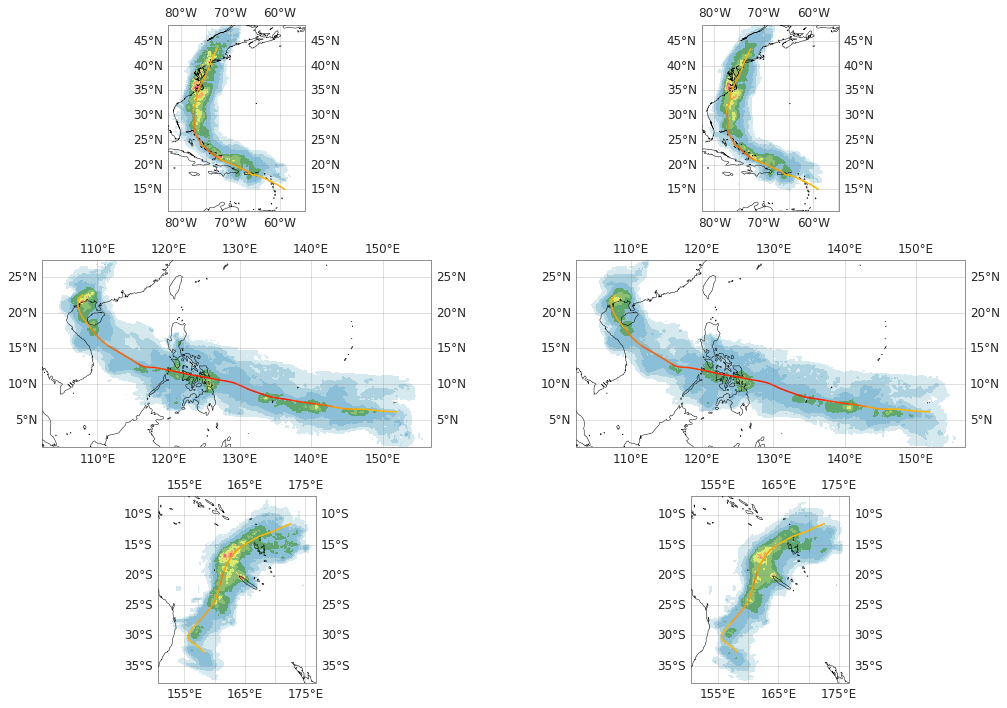

In [19]:
# set style
levels = [0,1,2,5,10,25,50,100,150,200,250,300]
# levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1,2,3,20,50]
levels = [0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50,100,150,200,250,300,400,500]
sns.set_style("white")
sns.set_context("notebook")
# define cmap
precip_cmap,precip_norm = make_cmap(high_vals=True)
fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharey=False,subplot_kw={'projection': ccrs.PlateCarree()})
# plot storm
axes[0,0] = plot_accumulated(accumulated_ds_1['precipitation'],accumulated_ds_1['lat'].values,accumulated_ds_1['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,centre_lons=centre_lons_1,intensity=intensity_1,ax=axes[0,0])
axes[0,1] = plot_accumulated(accumulated_ds_pred_1['precipitation'],accumulated_ds_pred_1['lat'].values,accumulated_ds_pred_1['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,centre_lons=centre_lons_1,intensity=intensity_1,ax=axes[0,1])

axes[1,0] = plot_accumulated(accumulated_ds_2['precipitation'],accumulated_ds_2['lat'].values,accumulated_ds_2['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_2,centre_lons=centre_lons_2,intensity=intensity_2,ax=axes[1,0])
axes[1,1] = plot_accumulated(accumulated_ds_pred_2['precipitation'],accumulated_ds_pred_2['lat'].values,accumulated_ds_pred_2['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_2,centre_lons=centre_lons_2,intensity=intensity_2,ax=axes[1,1])

axes[2,0] = plot_accumulated(accumulated_ds_4['precipitation'],accumulated_ds_4['lat'].values,accumulated_ds_4['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_4,centre_lons=centre_lons_4,intensity=intensity_4,ax=axes[2,0])
axes[2,1] = plot_accumulated(accumulated_ds_pred_4['precipitation'],accumulated_ds_pred_4['lat'].values,accumulated_ds_pred_4['lon'].values,vmin=0,vmax=500,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_4,centre_lons=centre_lons_4,intensity=intensity_4,ax=axes[2,1])

plt.tight_layout()

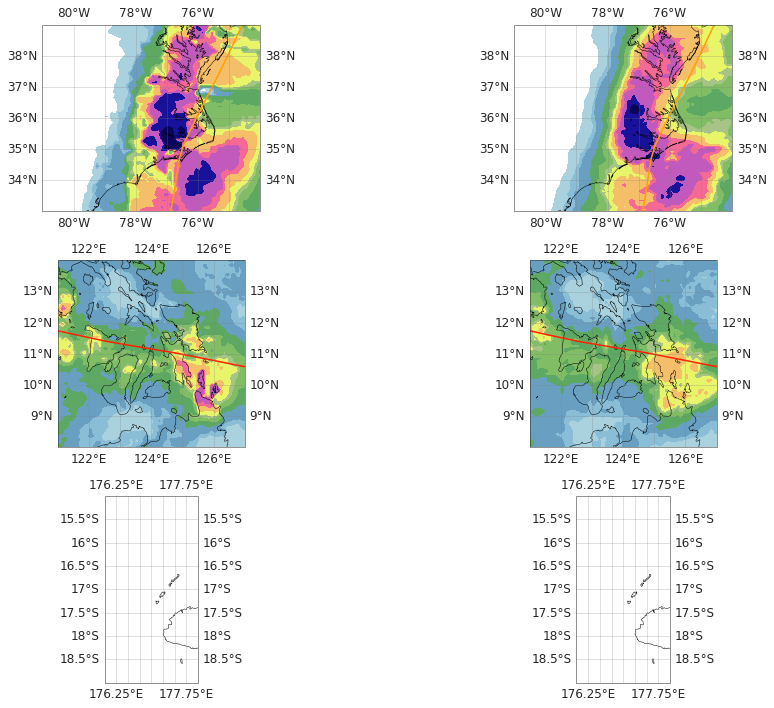

In [22]:

levels = [0, 1,2,3,4,5,10,15,20,25,40,50,100,150,200,250,300,350,400]
# levels = [0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50]#100,150,200,250,300,350,400,500]
# levels = np.arange(0,500,10)
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,120,130, 150,180,200,250,300,350,400,450,500]
sns.set_style("white")
sns.set_context("notebook")
# define cmap
precip_cmap,precip_norm = make_cmap()

fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharey=False,subplot_kw={'projection': ccrs.PlateCarree()})
extent_1 = [119, 22, 122, 25]
extent_2 = [-81, 33, -76, 39]
extent_3 = [-73, 16, -68, 21]

# Irene 2011233N15301 validation NA
xlim_1 = (-81,-74)
ylim_1 = (33,39)

# Haiyan 2013306N07162 validation WP
xlim_2 = (121,127)
ylim_2 = (8,14)

# Daman 1992044S09181 extreme valid SP (fiji)
xlim_4 = (176,178)
ylim_4 = (-19,-15)


# plot storm
axes[0,0] = plot_accumulated(accumulated_ds_1['precipitation'],accumulated_ds_1['lat'].values,accumulated_ds_1['lon'].values,
							vmin=0,vmax=300,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,
							centre_lons=centre_lons_1,intensity=intensity_1,ax=axes[0,0],mask_oceans=True)
axes[0,1] = plot_accumulated(accumulated_ds_pred_1['precipitation'],accumulated_ds_pred_1['lat'].values,accumulated_ds_pred_1['lon'].values,
							vmin=0,vmax=300,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,centre_lons=centre_lons_1,
							intensity=intensity_1,ax=axes[0,1],mask_oceans=True)
axes[0,0].set_xlim(xlim_1)
axes[0,0].set_ylim(ylim_1)
axes[0,1].set_xlim(xlim_1)
axes[0,1].set_ylim(ylim_1)


axes[1,0] = plot_accumulated(accumulated_ds_2['precipitation'],accumulated_ds_2['lat'].values,
							accumulated_ds_2['lon'].values,vmin=0,vmax=300,cmap=precip_cmap,levels = levels,plot='ax',
							centre_lats=centre_lats_2,centre_lons=centre_lons_2,intensity=intensity_2,
							ax=axes[1,0],mask_oceans=True)
axes[1,1] = plot_accumulated(accumulated_ds_pred_2['precipitation'],accumulated_ds_pred_2['lat'].values,
							accumulated_ds_pred_2['lon'].values,vmin=0,vmax=300,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_2,centre_lons=centre_lons_2,intensity=intensity_2,
							ax=axes[1,1],mask_oceans=True)
axes[1,0].set_xlim(xlim_2)
axes[1,0].set_ylim(ylim_2)
axes[1,1].set_xlim(xlim_2)
axes[1,1].set_ylim(ylim_2)

axes[2,0] = plot_accumulated(accumulated_ds_4['precipitation'],accumulated_ds_4['lat'].values,
							accumulated_ds_4['lon'].values,vmin=0,vmax=300,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_4,centre_lons=centre_lons_4,intensity=intensity_4,
							ax=axes[2,0],mask_oceans=True)
axes[2,1] = plot_accumulated(accumulated_ds_pred_4['precipitation'],accumulated_ds_pred_4['lat'].values,
							accumulated_ds_pred_4['lon'].values,vmin=0,vmax=300,cmap=precip_cmap,levels = levels,
							plot='ax',centre_lats=centre_lats_4,centre_lons=centre_lons_4,intensity=intensity_4,
							ax=axes[2,1],mask_oceans=True)
axes[2,0].set_xlim(xlim_4)
axes[2,0].set_ylim(ylim_4)
axes[2,1].set_xlim(xlim_4)
axes[2,1].set_ylim(ylim_4)

plt.tight_layout()

In [13]:
print(sid_2009268N14128)

[5395, 5396, 5397, 5398, 5399, 5400, 5401, 5402, 5403, 5404, 5405, 5406, 5407, 5408, 5409, 5410, 5411, 5412, 5413, 5414, 5415, 5416, 5417, 5418, 5419, 5420, 5421, 5422, 5423, 5424]


In [12]:
print(meta_extreme_valid)

      Unnamed: 0  Unnamed: 0.1            sid  centre_lat  centre_lon
0              0             0  2010263N15149     19.0400     144.173
1              1             1  2010263N15149     19.5750     141.875
2              2             2  2010263N15149     21.5500     140.950
3              3             3  2010263N15149     28.5000     141.700
4              4             4  2010263N15149     19.1794     143.823
...          ...           ...            ...         ...         ...
5420          25            25  2009268N14128     15.4000     108.900
5421          26            26  2009268N14128     15.4072     120.463
5422          27            27  2009268N14128     15.5106     114.948
5423          28            28  2009268N14128     15.9592     111.521
5424          29            29  2009268N14128     15.3444     108.500

[5425 rows x 5 columns]


In [151]:
print(accumulated_ds['lat'].values)
print(accumulated_ds['lon'].values)

[12.350001 12.45     12.549998 12.649997 12.749995 12.850001 12.95
 13.049998 13.149997 13.249995 13.350001 13.45     13.549998 13.649997
 13.749995 13.850001 13.95     14.049998 14.149997 14.249995 14.350001
 14.45     14.549998 14.649997 14.749995 14.850001 14.95     15.049998
 15.149997 15.249995 15.350001 15.45     15.549998 15.649997 15.749995
 15.850001 15.95     16.05     16.149998 16.249996 16.350002 16.45
 16.55     16.649998 16.749996 16.850002 16.95     17.05     17.149998
 17.249996 17.350002 17.45     17.55     17.649998 17.749996 17.850002
 17.95     18.05     18.149998 18.249996 18.350002 18.45     18.55
 18.649998 18.749996 18.850002 18.95     19.05     19.149998 19.249996
 19.350002 19.45     19.55     19.649998 19.749996 19.850002 19.95
 20.05     20.149998 20.249996 20.350002 20.45     20.55     20.649998
 20.749996 20.850002 20.95     21.05     21.149998 21.249996 21.350002
 21.45     21.55     21.649998 21.749996 21.850002 21.95     22.05
 22.149998 22.249996]
[136

In [220]:
fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
d = Dataset(fp, 'r')
lat = d.variables['lat'][:] #lat
lon = d.variables['lon'][:] #lon

print(lat)
print(lon)

[-89.95001  -89.850006 -89.75     ...  89.75      89.85      89.95    ]
[-179.95    -179.84999 -179.75    ...  179.75002  179.85002  179.95   ]


In [12]:
print(precip_norm)

In [57]:
print(sid_2015211N13162)
print(sid_2011233N15301)
print(sid_1998259N10335)

[836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908]
[11674, 11675, 11676, 11677, 11678, 11679, 11680, 11681, 11682, 11683, 11684, 11685, 11686, 11687, 11688, 11689, 11690, 11691, 11692, 11693, 11694, 11695, 11696, 11697, 11698, 11699, 11700, 11701, 11702, 11703, 11704, 11705, 11706, 11707, 11708, 11709, 11710, 11711, 11712, 11713, 11714, 11715, 11716, 11717, 11718, 11719, 11720, 11721, 11722, 11723, 11724, 11725, 11726, 11727, 11728]
[4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4

In [69]:
print(meta['centre_lat'][11728])
print(meta['centre_lon'][11728])
print(meta['sid'][11728])

39.4
-74.4
2011233N15301


In [67]:
print(meta)

       Unnamed: 0  Unnamed: 0.1            sid  centre_lat  centre_lon
0               0             0  1986254N22309     26.8000    -54.8000
1               1             1  1986254N22309     29.5000    -54.9000
2               2             2  1986254N22309     31.4000    -50.9000
3               3             3  1986254N22309     38.3000    -48.4000
4               4             4  1986254N22309     24.5724    -53.1651
...           ...           ...            ...         ...         ...
16248          68            68  2007027S07069    -18.6625     67.2658
16249          69            69  2007027S07069    -18.9525     66.7858
16250          70            70  2007027S07069    -20.4308     64.6074
16251          71            71  2007027S07069    -22.0034     63.2224
16252          72            72  2007027S07069    -24.7800     63.0066

[16253 rows x 5 columns]


In [17]:
print(np.where(meta['sid'] == '1995189N11257'))

(array([1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354,
       1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365,
       1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376,
       1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387,
       1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398,
       1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406]),)


In [18]:
valid_sids = list(dict.fromkeys(meta['sid']))
print('valid sids',valid_sids)

valid sids ['1986254N22309', '1991352S08066', '1980219N15258', '2011013S15151', '2002063S11066', '1989142N11114', '2015209N07248', '1985249N13265', '2017122S13170', '2013046S20042', '1996319N11283', '2019210N11253', '1983221N13254', '1991210N11253', '1993083S12181', '1981307N17279', '1995260N15255', '2010169N13266', '1989044S12102', '2007240N17153', '2014279N11096', '2016296N11262', '2001212N10158', '2015273N12130', '1981297N11261', '2008275N16245', '1980208N23153', '2009254N14130', '1992302N06150', '1995189N11257', '2000333S11140', '1989230N14338', '1989053S14210', '1985199N08143', '2009121N13124', '2006228N13247', '2016255N12247', '2018244N14252', '2008083S12102', '1982227N09140', '2015152N12258', '1996021S16152', '2010331S07089', '1996208N20165', '1992262N34301', '1999208N06139', '1995206N15133', '2018300N25315', '2013019S12174', '2005261N14252', '1986270N05178', '1993262N27298', '1993164N04160', '2013348S10082', '2015030S16161', '1989153N04144', '2001245N13326', '1981306S03096', '1